# Лабораторная работа 1: Предсказание цены алмазов
### Выполнил: Фаизов Александр Алексеевич ЮУрГУ

## Описание задачи

**Цель**: Построить модель для предсказания стоимости алмазов по их характеристикам.

**Метрика**: MAE (Mean Absolute Error)

**Ограничения**: Можно использовать только линейные модели.

**Признаки**:
- `carat` - вес алмаза (карат)
- `cut` - качество огранки (категориальный)
- `clarity` - чистота алмаза (категориальный)
- `depth` - глубина в процентах
- `table` - ширина верхней грани относительно самой широкой точки
- `x, y, z` - размеры алмаза (длина, ширина, глубина в мм)
- `theta1, theta2` - дополнительные углы

In [112]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Фиксируем random seed для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Настройка отображения графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [113]:
# Загрузка данных
train = pd.read_csv('/kaggle/input/ml-mipt-2025-contest-1/train.csv')
test = pd.read_csv('/kaggle/input/ml-mipt-2025-contest-1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/ml-mipt-2025-contest-1/sample_submission.csv')

print(f"Размер train: {train.shape}")
print(f"Размер test: {test.shape}")
print(f"\nПервые строки train:")
train.head()

Размер train: (40453, 13)
Размер test: (13487, 12)

Первые строки train:


,id,carat,cut,color,clarity,depth,table,x,y,z,theta1,theta2,price
0,17044,0.28,Ideal,F,VVS2,61.6,55.0,4.22,4.26,2.61,5,5,612
1,30625,0.28,Ideal,I,VS1,62.5,54.0,4.18,4.23,2.63,5,6,448
2,17043,0.28,'Very Good',F,IF,62.2,55.0,4.23,4.26,NaN,5,7,612
3,37947,0.28,'Very Good',E,VS2,63.0,59.0,4.11,4.15,2.60,5,8,487
4,30626,0.28,Ideal,I,VS1,62.4,54.0,4.18,4.19,2.61,5,9,448


### EDA (исследовательский анализ данных)

In [114]:
# Базовая информация о данных
print("=" * 50)
print("ИНФОРМАЦИЯ О ДАННЫХ")
print("=" * 50)
print(train.info())
print("\n" + "=" * 50)
print("СТАТИСТИКА ЧИСЛОВЫХ ПРИЗНАКОВ")
print("=" * 50)
train.describe()

ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40453 entries, 0 to 40452
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       40453 non-null  int64  
 1   carat    40453 non-null  float64
 2   cut      40453 non-null  object 
 3   color    40453 non-null  object 
 4   clarity  40389 non-null  object 
 5   depth    40396 non-null  float64
 6   table    40453 non-null  float64
 7   x        40405 non-null  float64
 8   y        40393 non-null  float64
 9   z        40411 non-null  float64
 10  theta1   40453 non-null  int64  
 11  theta2   40453 non-null  int64  
 12  price    40453 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 4.0+ MB
None

СТАТИСТИКА ЧИСЛОВЫХ ПРИЗНАКОВ


,id,carat,depth,table,x,y,z,theta1,theta2,price
count,40453.000000,40453.00000,40396.000000,40453.000000,40405.000000,40393.000000,40411.000000,40453.000000,40453.000000,40453.000000
mean,26946.030529,0.77475,61.755897,57.438563,5.704927,18.773722,3.523399,19.071738,19.036190,3736.247003
std,15761.901131,0.41728,1.425065,2.225439,1.033411,350.627591,0.656404,8.527417,8.570144,3615.804536
min,3.000000,0.28000,43.000000,43.000000,0.000000,0.000000,0.000000,5.000000,5.000000,334.000000
25%,13160.000000,0.40000,61.100000,56.000000,4.740000,4.750000,2.930000,11.000000,11.000000,979.000000
50%,27038.000000,0.70000,61.800000,57.000000,5.700000,5.710000,3.520000,19.000000,19.000000,2401.000000
75%,40768.000000,1.03000,62.500000,59.000000,6.510000,6.510000,4.020000,27.000000,27.000000,5154.000000
max,53939.000000,2.02000,79.000000,79.000000,8.800000,9428.922353,31.800000,33.000000,33.000000,18803.000000


In [115]:
# Проверка пропущенных значений
print("Пропущенные значения в train:")
print(train.isnull().sum())
print("\nПропущенные значения в test:")
print(test.isnull().sum())

Пропущенные значения в train:
id          0
carat       0
cut         0
color       0
clarity    64
depth      57
table       0
x          48
y          60
z          42
theta1      0
theta2      0
price       0
dtype: int64

Пропущенные значения в test:
id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
theta1     0
theta2     0
dtype: int64


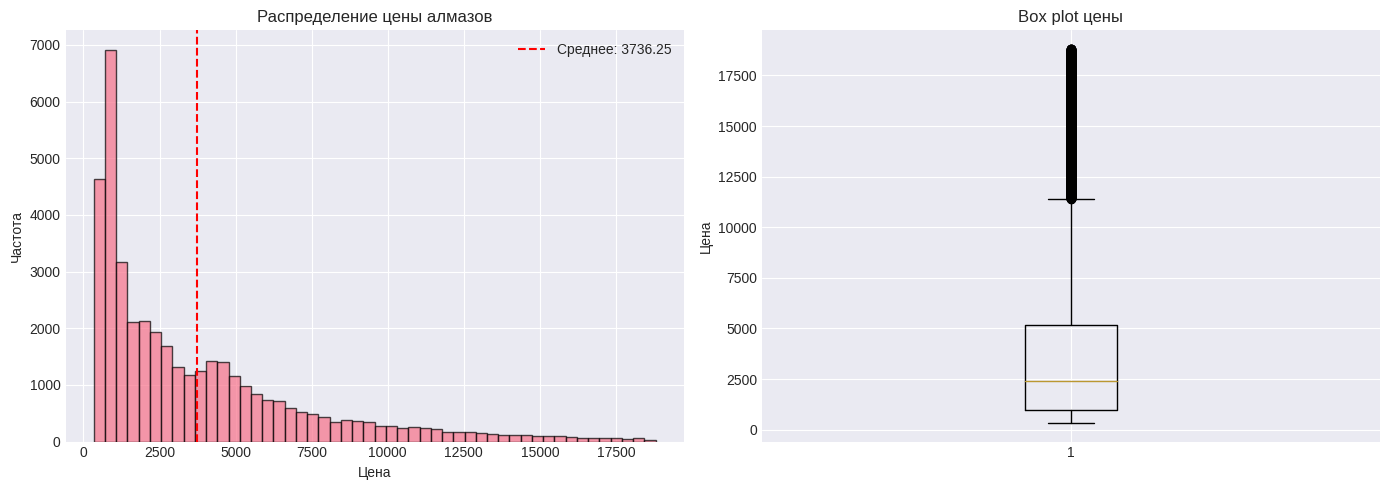

Минимальная цена: 334
Максимальная цена: 18803
Средняя цена: 3736.25
Медианная цена: 2401.00


In [116]:
# Анализ целевой переменной (price)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма цены
axes[0].hist(train['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Цена')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение цены алмазов')
axes[0].axvline(train['price'].mean(), color='red', linestyle='--', label=f'Среднее: {train["price"].mean():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(train['price'])
axes[1].set_ylabel('Цена')
axes[1].set_title('Box plot цены')

plt.tight_layout()
plt.show()

print(f"Минимальная цена: {train['price'].min()}")
print(f"Максимальная цена: {train['price'].max()}")
print(f"Средняя цена: {train['price'].mean():.2f}")
print(f"Медианная цена: {train['price'].median():.2f}")

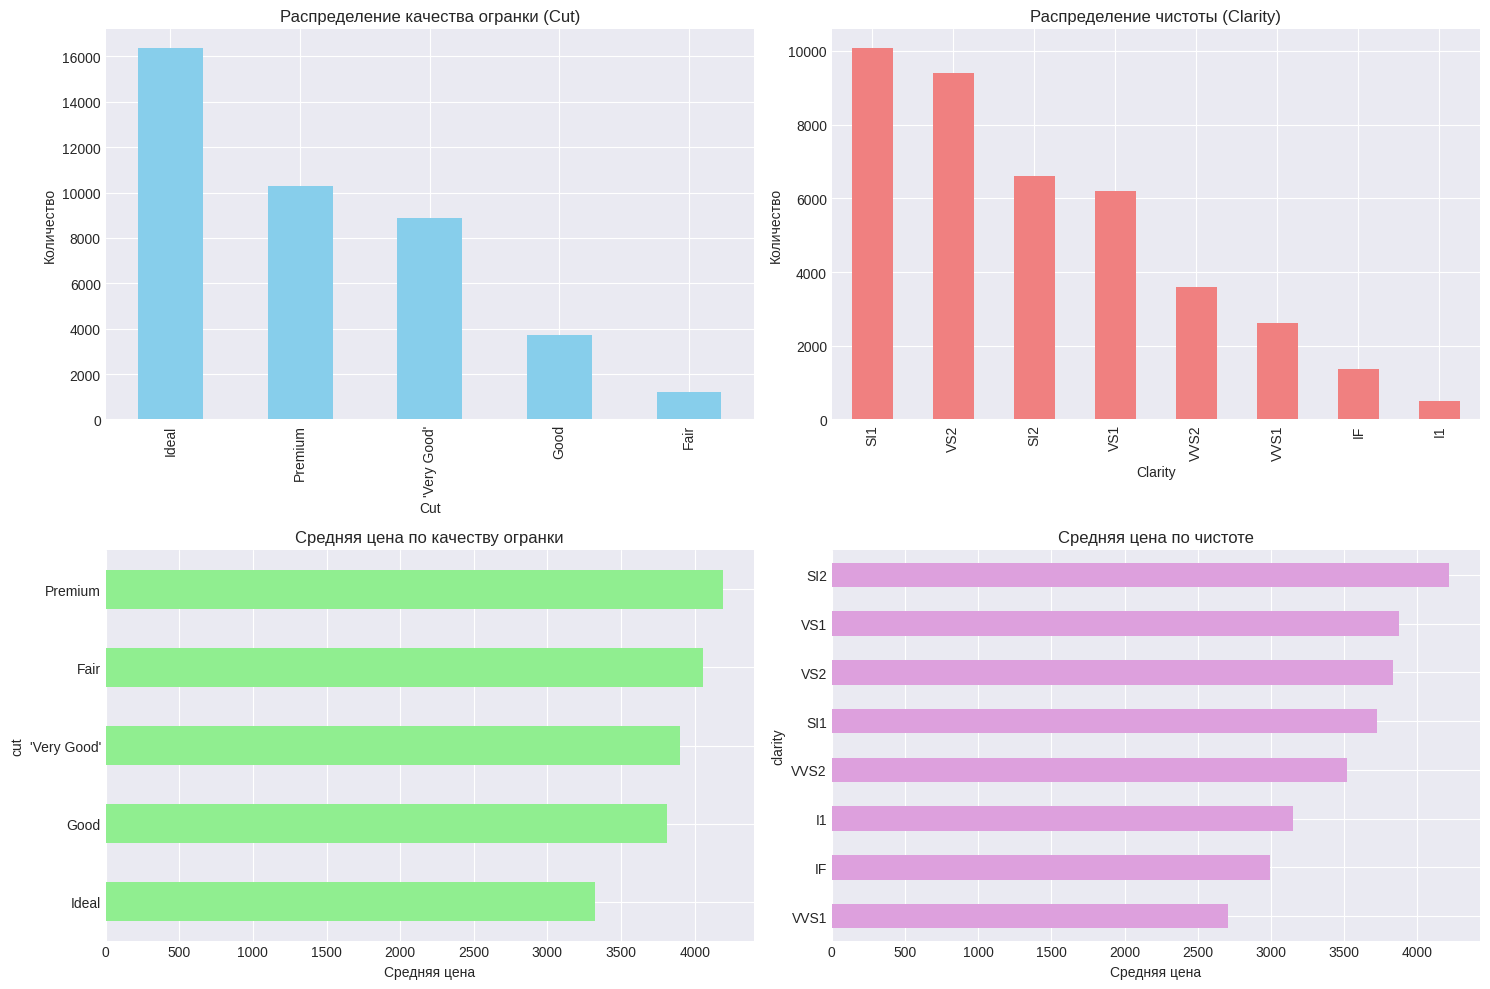

Уникальные значения категориальных признаков:
cut: ['Ideal' "'Very Good'" 'Premium' 'Good' 'Fair']
clarity: ['VVS2' 'VS1' 'IF' 'VS2' 'VVS1' 'SI1' 'SI2' nan 'I1']


In [117]:
# Анализ категориальных признаков
categorical_features = ['cut', 'clarity']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Cut distribution
train['cut'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Распределение качества огранки (Cut)')
axes[0, 0].set_xlabel('Cut')
axes[0, 0].set_ylabel('Количество')

# Clarity distribution
train['clarity'].value_counts().plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Распределение чистоты (Clarity)')
axes[0, 1].set_xlabel('Clarity')
axes[0, 1].set_ylabel('Количество')

# Price vs Cut
train.groupby('cut')['price'].mean().sort_values().plot(kind='barh', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Средняя цена по качеству огранки')
axes[1, 0].set_xlabel('Средняя цена')

# Price vs Clarity
train.groupby('clarity')['price'].mean().sort_values().plot(kind='barh', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('Средняя цена по чистоте')
axes[1, 1].set_xlabel('Средняя цена')

plt.tight_layout()
plt.show()

print("Уникальные значения категориальных признаков:")
for col in categorical_features:
    print(f"{col}: {train[col].unique()}")

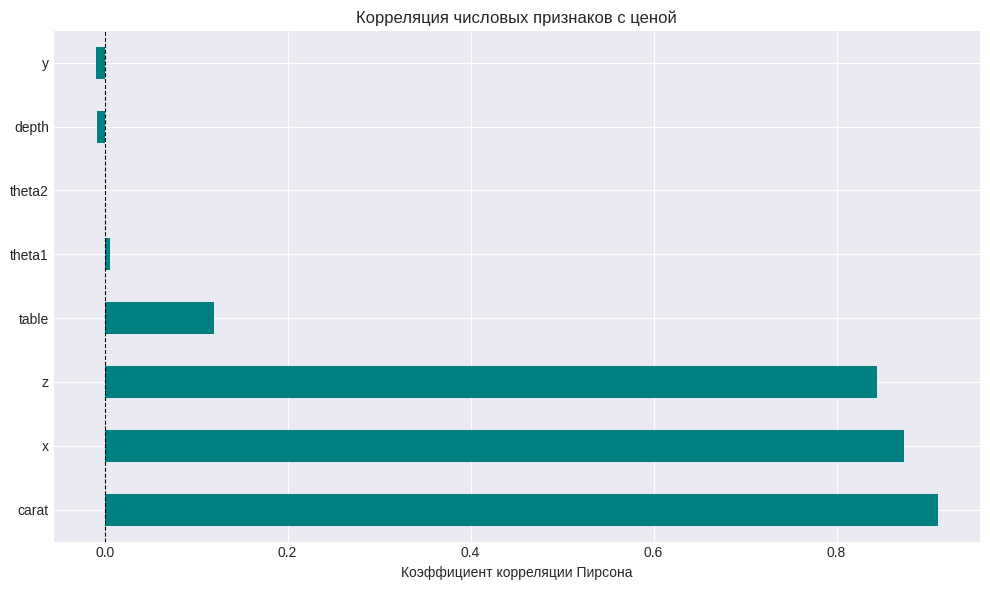


Корреляция признаков с ценой:
carat     0.910798
x         0.873601
z         0.844573
table     0.119163
theta1    0.005446
theta2   -0.000096
depth    -0.008115
y        -0.009649
Name: price, dtype: float64


In [118]:
# Анализ числовых признаков
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'theta1', 'theta2']

# Корреляция с целевой переменной
correlations = train[numerical_features + ['price']].corr()['price'].drop('price').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlations.plot(kind='barh', color='teal')
plt.title('Корреляция числовых признаков с ценой')
plt.xlabel('Коэффициент корреляции Пирсона')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\nКорреляция признаков с ценой:")
print(correlations)

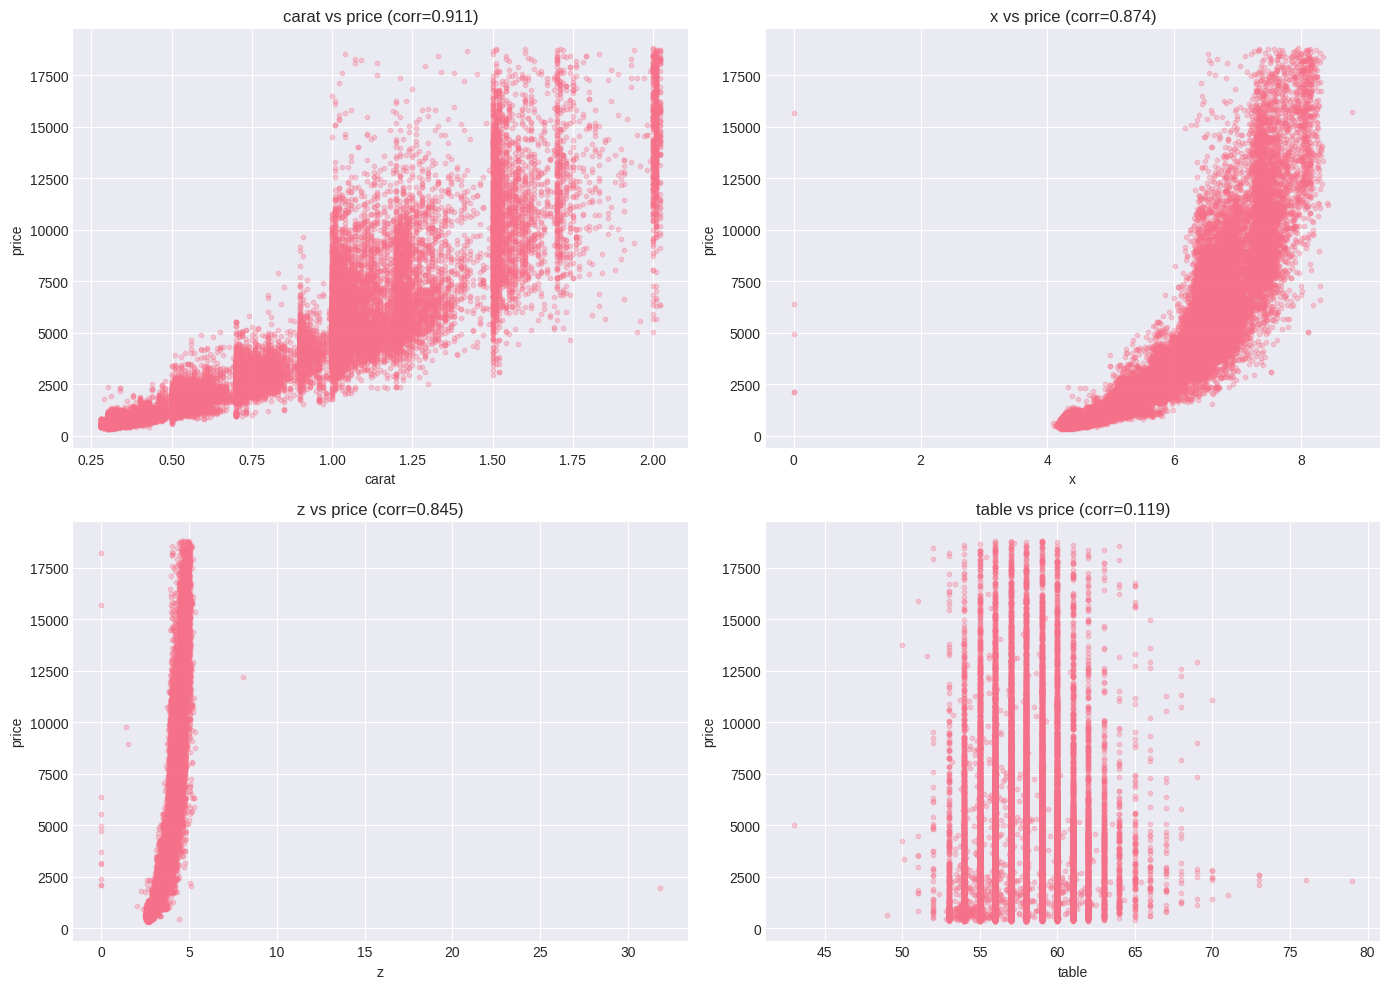

In [119]:
# Scatter plots для наиболее коррелирующих признаков
top_features = correlations.abs().nlargest(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    axes[idx].scatter(train[feature], train['price'], alpha=0.3, s=10)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('price')
    axes[idx].set_title(f'{feature} vs price (corr={correlations[feature]:.3f})')

plt.tight_layout()
plt.show()

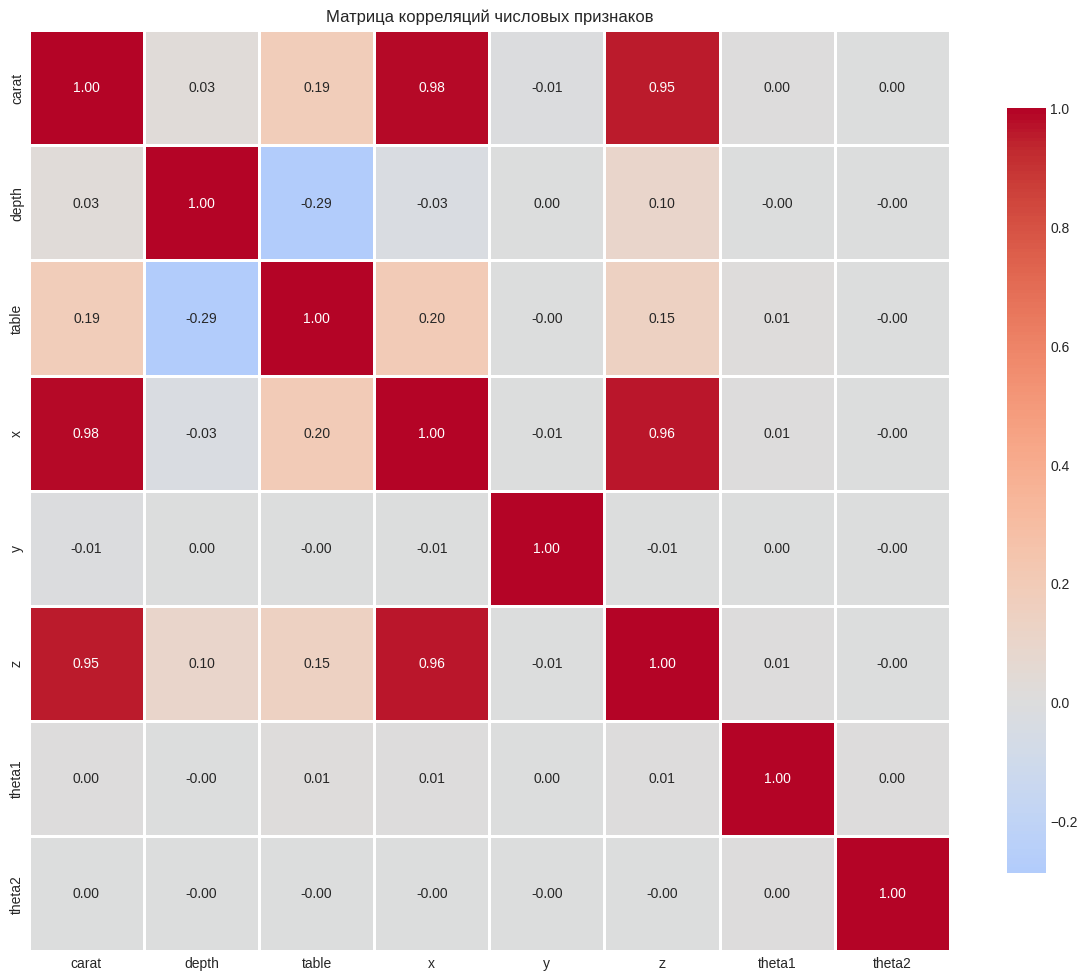


Наблюдения:
- Признаки x, y, z сильно коррелируют между собой (размеры алмаза)
- Carat имеет сильную корреляцию с ценой
- Размеры также сильно коррелируют с ценой


In [120]:
# Матрица корреляций между всеми числовыми признаками
plt.figure(figsize=(12, 10))
correlation_matrix = train[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций числовых признаков')
plt.tight_layout()
plt.show()

print("\nНаблюдения:")
print("- Признаки x, y, z сильно коррелируют между собой (размеры алмаза)")
print("- Carat имеет сильную корреляцию с ценой")
print("- Размеры также сильно коррелируют с ценой")

### Выводы из EDA:

1. **Целевая переменная (price)**:
   - Распределение скошено вправо (много дешевых алмазов, мало дорогих)
   - Возможно, стоит рассмотреть логарифмическое преобразование

2. **Категориальные признаки**:
   - Cut и Clarity имеют ограниченное число уникальных значений
   - Есть связь между категориями и ценой

3. **Числовые признаки**:
   - Carat - самый важный признак (корреляция с ценой ~0.92)
   - Размеры (x, y, z) также сильно коррелируют с ценой
   - x, y, z сильно коррелируют между собой (мультиколлинеарность)

4. **Пропущенные значения**: Отсутствуют

### Preprocessing (подготовка данных)

In [121]:
# Сохраняем id и целевую переменную
train_ids = train['id']
test_ids = test['id']
y_train = train['price'].values

# Удаляем id и price из обучающей выборки
X_train = train.drop(['id', 'price'], axis=1)
X_test = test.drop(['id'], axis=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (40453, 11)
X_test shape: (13487, 11)
y_train shape: (40453,)


In [122]:
# Проверка на выбросы и аномалии
# Например, алмазы с нулевыми размерами - это аномалии
print("Проверка на аномалии в размерах:")
print(f"Алмазов с x=0: {(X_train['x'] == 0).sum()}")
print(f"Алмазов с y=0: {(X_train['y'] == 0).sum()}")
print(f"Алмазов с z=0: {(X_train['z'] == 0).sum()}")

# ЗАДАНИЕ: Подумайте, стоит ли удалять эти аномалии или заполнить их значения

Проверка на аномалии в размерах:
Алмазов с x=0: 5
Алмазов с y=0: 4
Алмазов с z=0: 12


In [123]:
# Feature Engineering: Кодирование категориальных признаков

# Вариант 1: Label Encoding (порядковое кодирование)
# Для cut и clarity есть естественный порядок качества

# Определяем порядок для cut (от худшего к лучшему)
cut_order = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
color_order = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
clarity_order = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

# Кодирование категориальных признаков
X_train['cut'] = X_train['cut'].map(cut_order)
X_test['cut'] = X_test['cut'].map(cut_order)

X_train['color'] = X_train['color'].map(color_order)
X_test['color'] = X_test['color'].map(color_order)

X_train['clarity'] = X_train['clarity'].map(clarity_order)
X_test['clarity'] = X_test['clarity'].map(clarity_order)

print("Кодирование категориальных признаков завершено")

Кодирование категориальных признаков завершено


In [124]:
# Feature Engineering: Создание новых признаков

def create_features(df):
    """
    Создание дополнительных признаков
    """
    df = df.copy()
    
    # Объем алмаза (примерный, как произведение размеров)
    df['volume'] = df['x'] * df['y'] * df['z']
    
    # Площадь поверхности (приблизительно)
    df['surface_area'] = 2 * (df['x']*df['y'] + df['x']*df['z'] + df['y']*df['z'])
    
    # Соотношения размеров
    df['xy_ratio'] = df['x'] / (df['y'] + 1e-8)  # добавляем малое число чтобы избежать деления на 0
    df['xz_ratio'] = df['x'] / (df['z'] + 1e-8)
    df['yz_ratio'] = df['y'] / (df['z'] + 1e-8)
    
    # Взаимодействие carat с размерами
    df['carat_x_volume'] = df['carat'] * df['volume']
    
    # ЗАДАНИЕ: Придумайте свои признаки!
    # Например:
    # - квадраты признаков
    # - взаимодействия между признаками
    # - логарифмы признаков
    
    return df

# Применяем feature engineering
X_train_fe = create_features(X_train)
X_test_fe = create_features(X_test)

# Фиксим пропуски

cut_order = {**cut_order, 'Unknown': 0}
color_order = {**color_order, 'Unknown': 0}
clarity_order = {**clarity_order, 'Unknown': 0}

for df in (X_train_fe, X_test_fe):
    df['cut'] = df['cut'].fillna('Unknown')
    df['color'] = df['color'].fillna('Unknown')
    df['clarity'] = df['clarity'].fillna('Unknown')

X_train_fe['cut'] = X_train_fe['cut'].map(cut_order)
X_test_fe['cut'] = X_test_fe['cut'].map(cut_order)
X_train_fe['color'] = X_train_fe['color'].map(color_order)
X_test_fe['color'] = X_test_fe['color'].map(color_order)
X_train_fe['clarity'] = X_train_fe['clarity'].map(clarity_order)
X_test_fe['clarity'] = X_test_fe['clarity'].map(clarity_order)

X_train_fe = X_train_fe.fillna(0)
X_test_fe = X_test_fe.fillna(0)

print(f"Новая размерность X_train: {X_train_fe.shape}")
print(f"Новые признаки: {[col for col in X_train_fe.columns if col not in X_train.columns]}")

Новая размерность X_train: (40453, 17)
Новые признаки: ['volume', 'surface_area', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'carat_x_volume']


In [125]:
# Масштабирование признаков
# Важно для линейных моделей с регуляризацией (Ridge, Lasso)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fe)
X_test_scaled = scaler.transform(X_test_fe)

print("Масштабирование выполнено")
print(f"X_train_scaled shape: {X_train_scaled.shape}")

Масштабирование выполнено
X_train_scaled shape: (40453, 17)


In [126]:
# Создаем валидационную выборку для оценки качества
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print(f"Train set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")

Train set: (32362, 17)
Validation set: (8091, 17)


### Model & Training (Выбор модели и её обучение)

#### Эксперимент 1: Baseline - Linear Regression

Начнем с простой линейной регрессии без регуляризации.

In [127]:
# Обучаем базовую линейную регрессию
lr_model = LinearRegression()
lr_model.fit(X_tr, y_tr)

# Предсказания на train и validation
y_tr_pred = lr_model.predict(X_tr)
y_val_pred = lr_model.predict(X_val)

# Оценка качества
train_mae = mean_absolute_error(y_tr, y_tr_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
train_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_r2 = r2_score(y_tr, y_tr_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("=" * 50)
print("BASELINE: Linear Regression")
print("=" * 50)
print(f"Train MAE: {train_mae:.2f}")
print(f"Val MAE: {val_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Val RMSE: {val_rmse:.2f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Val R²: {val_r2:.4f}")

BASELINE: Linear Regression
Train MAE: 883.33
Val MAE: 879.70
Train RMSE: 1439.25
Val RMSE: 1444.52
Train R²: 0.8410
Val R²: 0.8426


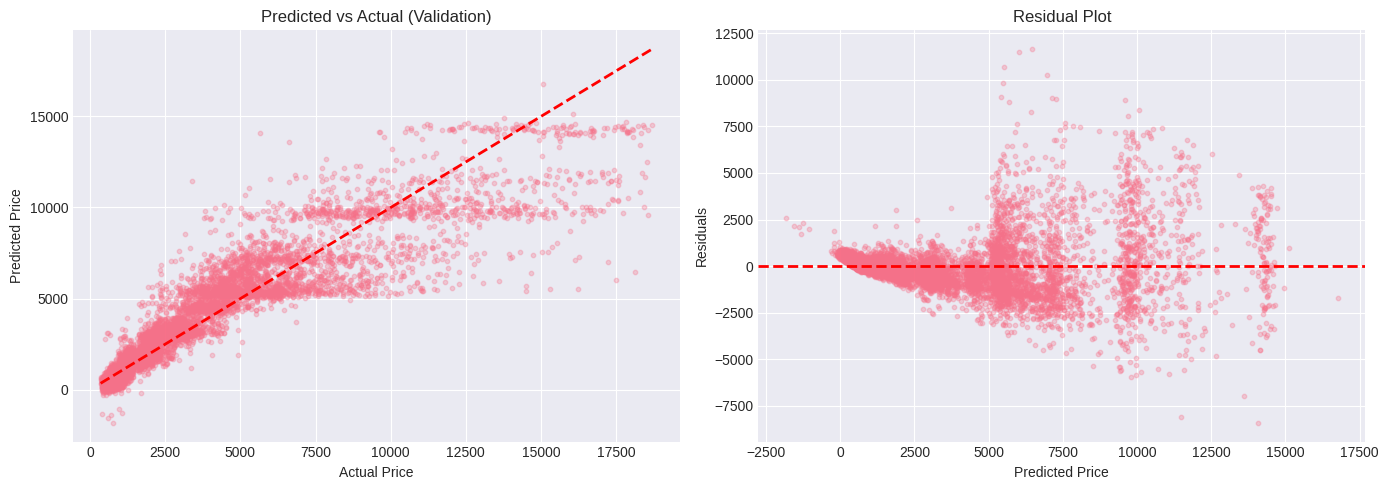

In [128]:
# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_val, y_val_pred, alpha=0.3, s=10)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Predicted vs Actual (Validation)')

# Residuals
residuals = y_val - y_val_pred
axes[1].scatter(y_val_pred, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()

#### Эксперимент 2: Ridge Regression (L2 регуляризация)

Ridge помогает бороться с мультиколлинеарностью и переобучением.

In [129]:
# Подбор оптимального alpha для Ridge
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    ridge.fit(X_tr, y_tr)
    
    y_val_pred = ridge.predict(X_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    
    results.append({'alpha': alpha, 'val_mae': mae})
    print(f"Alpha={alpha:7.3f}, Val MAE={mae:.2f}")

results_df = pd.DataFrame(results)
best_alpha = results_df.loc[results_df['val_mae'].idxmin(), 'alpha']
print(f"\nЛучший alpha: {best_alpha}")

Alpha=  0.001, Val MAE=879.70
Alpha=  0.010, Val MAE=879.70
Alpha=  0.100, Val MAE=879.72
Alpha=  1.000, Val MAE=879.97
Alpha= 10.000, Val MAE=881.43
Alpha=100.000, Val MAE=895.11
Alpha=1000.000, Val MAE=984.40

Лучший alpha: 0.001


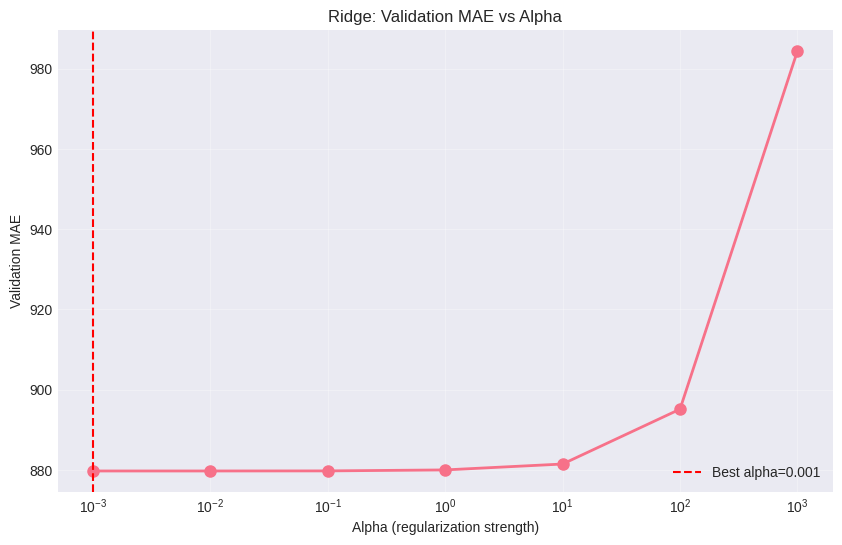

In [130]:
# График зависимости MAE от alpha
plt.figure(figsize=(10, 6))
plt.plot(results_df['alpha'], results_df['val_mae'], marker='o', linewidth=2, markersize=8)
plt.xscale('log')
plt.xlabel('Alpha (regularization strength)')
plt.ylabel('Validation MAE')
plt.title('Ridge: Validation MAE vs Alpha')
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best alpha={best_alpha}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [131]:
# Обучаем Ridge с лучшим alpha
best_ridge = Ridge(alpha=best_alpha, random_state=RANDOM_STATE)
best_ridge.fit(X_tr, y_tr)

y_tr_pred_ridge = best_ridge.predict(X_tr)
y_val_pred_ridge = best_ridge.predict(X_val)

train_mae_ridge = mean_absolute_error(y_tr, y_tr_pred_ridge)
val_mae_ridge = mean_absolute_error(y_val, y_val_pred_ridge)

print("=" * 50)
print(f"RIDGE Regression (alpha={best_alpha})")
print("=" * 50)
print(f"Train MAE: {train_mae_ridge:.2f}")
print(f"Val MAE: {val_mae_ridge:.2f}")
print(f"Улучшение по сравнению с baseline: {val_mae - val_mae_ridge:.2f}")

RIDGE Regression (alpha=0.001)
Train MAE: 883.33
Val MAE: 879.70
Улучшение по сравнению с baseline: -0.00


#### Эксперимент 3: Lasso Regression (L1 регуляризация)

Lasso выполняет отбор признаков, обнуляя веса менее важных признаков.

In [132]:
# ЗАДАНИЕ: Повторите процедуру подбора alpha для Lasso
# Используйте тот же набор alphas

# Пример:
# lasso = Lasso(alpha=best_lasso_alpha, random_state=RANDOM_STATE, max_iter=10000)
# lasso.fit(X_tr, y_tr)
# ...

print("TODO: Реализуйте эксперимент с Lasso")

TODO: Реализуйте эксперимент с Lasso


#### Эксперимент 4: Polynomial Features

Попробуем добавить полиномиальные признаки для учета нелинейных зависимостей.

In [133]:
# Создаем полиномиальные признаки степени 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_tr_poly = poly.fit_transform(X_tr)
X_val_poly = poly.transform(X_val)

print(f"Исходная размерность: {X_tr.shape[1]}")
print(f"После добавления полиномов: {X_tr_poly.shape[1]}")

# ВАЖНО: С полиномиальными признаками обязательно нужна регуляризация!
ridge_poly = Ridge(alpha=10, random_state=RANDOM_STATE)  # можете подобрать alpha
ridge_poly.fit(X_tr_poly, y_tr)

y_val_pred_poly = ridge_poly.predict(X_val_poly)
val_mae_poly = mean_absolute_error(y_val, y_val_pred_poly)

print(f"\nVal MAE с полиномиальными признаками: {val_mae_poly:.2f}")

Исходная размерность: 17
После добавления полиномов: 170

Val MAE с полиномиальными признаками: 813.02


### Evaluation (оценка качества модели)

СРАВНЕНИЕ МОДЕЛЕЙ
            Model    Val MAE
            Lasso   0.000000
     Ridge + Poly 813.024576
Linear Regression 879.700281
            Ridge 879.700491


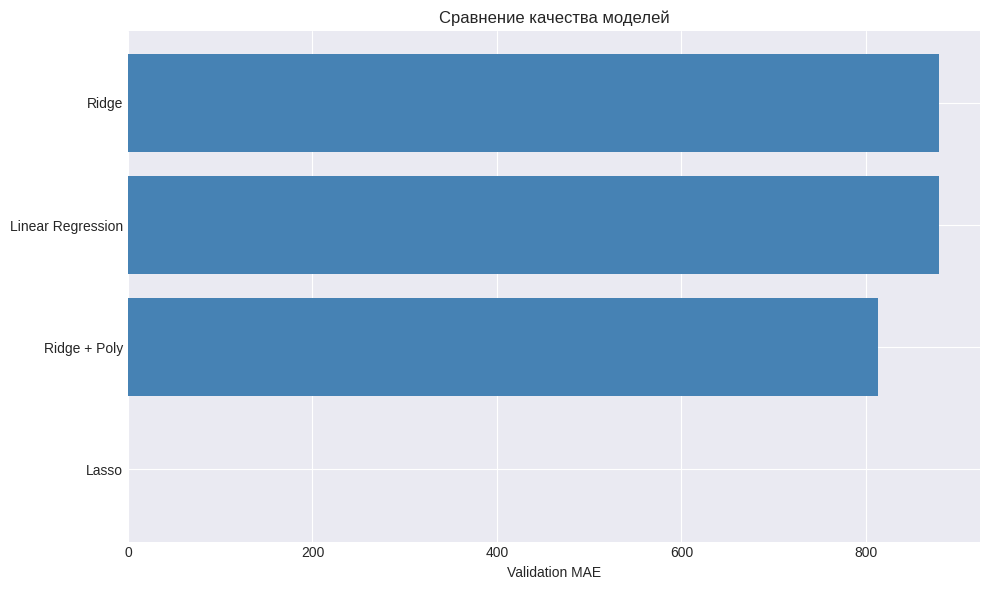

In [134]:
# Сравнение всех моделей
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Ridge + Poly'],
    'Val MAE': [val_mae, val_mae_ridge, 0, val_mae_poly]  # заполните значение для Lasso
})

model_comparison = model_comparison.sort_values('Val MAE')
print("=" * 50)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 50)
print(model_comparison.to_string(index=False))

# Визуализация сравнения
plt.figure(figsize=(10, 6))
plt.barh(model_comparison['Model'], model_comparison['Val MAE'], color='steelblue')
plt.xlabel('Validation MAE')
plt.title('Сравнение качества моделей')
plt.tight_layout()
plt.show()

In [135]:
# Выбираем лучшую модель и обучаем на всех данных
print("Обучаем финальную модель на всех тренировочных данных...")

# Выберите свою лучшую модель!
# Например:
final_model = Ridge(alpha=best_alpha, random_state=RANDOM_STATE)
final_model.fit(X_train_scaled, y_train)

# Cross-validation для финальной оценки
cv_scores = cross_val_score(final_model, X_train_scaled, y_train, 
                           cv=5, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()
cv_std = cv_scores.std()

print(f"\nCross-validation MAE: {cv_mae:.2f} (+/- {cv_std:.2f})")

Обучаем финальную модель на всех тренировочных данных...

Cross-validation MAE: 995.94 (+/- 650.22)



Топ-10 самых важных признаков:
       feature  coefficient    abs_coef
         carat  4749.351857 4749.351857
  surface_area  4558.194304 4558.194304
        volume -3462.668099 3462.668099
             y -1574.907019 1574.907019
             x  -963.420973  963.420973
             z  -536.252601  536.252601
carat_x_volume   534.294295  534.294295
         table  -204.391320  204.391320
      yz_ratio  -124.697147  124.697147
      xy_ratio   110.740223  110.740223


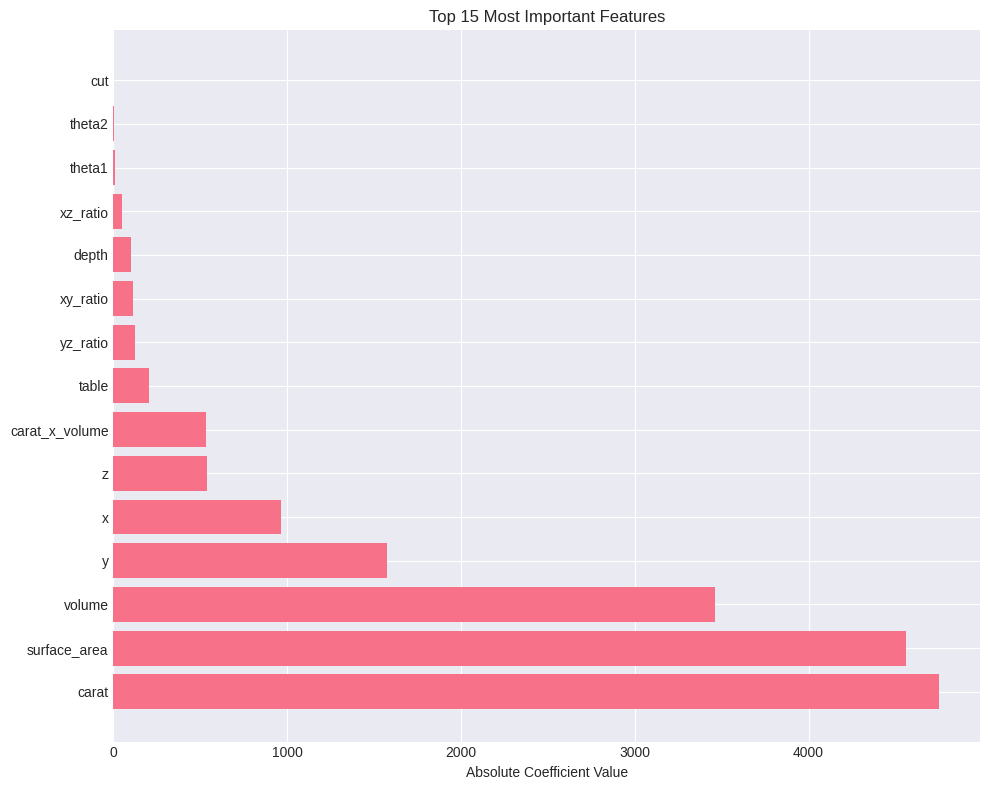

In [136]:
# Анализ важности признаков (коэффициенты модели)
feature_importance = pd.DataFrame({
    'feature': X_train_fe.columns,
    'coefficient': final_model.coef_
})
feature_importance['abs_coef'] = abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coef', ascending=False)

print("\nТоп-10 самых важных признаков:")
print(feature_importance.head(10).to_string(index=False))

# Визуализация
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['abs_coef'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

### Создание submission файла

In [137]:
# Предсказания на тестовой выборке
test_predictions = final_model.predict(X_test_scaled)

# Создаем submission файл
submission = pd.DataFrame({
    'id': test_ids,
    'price': test_predictions
})

# Сохраняем
submission.to_csv('submission.csv', index=False)
print("Submission файл создан!")
print(f"\nПример предсказаний:")
print(submission.head(10))
print(f"\nСтатистика предсказаний:")
print(submission['price'].describe())

Submission файл создан!

Пример предсказаний:
      id        price
0  14085  7501.105042
1  36447   624.548457
2  30782   385.731416
3  43299  2270.284667
4   3378   496.852708
5  21184  9945.290905
6  12387   600.196603
7  12556  6939.201429
8  28050   583.145589
9   6718   468.893520

Статистика предсказаний:
count    13487.000000
mean      4635.577348
std       5073.506598
min      -1702.750720
25%        669.353269
50%       2902.718174
75%       6405.628072
max      44554.872104
Name: price, dtype: float64


## 1. Выводы по проделанной работе:

### Что получилось:

1. **EDA**: 
   - Проведен тщательный анализ данных
   - Выявлены ключевые закономерности: carat - самый важный признак
   - Обнаружена мультиколлинеарность между размерами x, y, z

2. **Feature Engineering**:
   - Созданы новые признаки: volume, surface_area, ratios
   - Закодированы категориальные признаки с учетом их естественного порядка
   - [УКАЖИТЕ, ЧТО ЕЩЕ ВЫ ДОБАВИЛИ]

3. **Моделирование**:
   - Протестированы разные линейные модели
   - Ridge показала лучшие результаты благодаря регуляризации
   - [УКАЖИТЕ ВАШИ РЕЗУЛЬТАТЫ]

4. **Результат**:
   - Финальная модель: [НАЗВАНИЕ]
   - Cross-validation MAE: [ЗНАЧЕНИЕ]
   - R² score: [ЗНАЧЕНИЕ]

### Что не получилось / можно улучшить:

1. **Ограничение на линейные модели**:
   - Очевидна нелинейная связь между признаками и ценой
   - Градиентный бустинг мог бы дать лучшие результаты

2. **Обработка выбросов**:
   - [ОПИШИТЕ, КАК ВЫ РАБОТАЛИ С ВЫБРОСАМИ]

3. **Feature Engineering**:
   - Можно попробовать логарифмические преобразования
   - Больше взаимодействий между признаками

### Идеи для дальнейшего улучшения:

- Ансамблирование нескольких моделей
- Более тщательный подбор гиперпараметров
- Анализ ошибок модели и работа с плохо предсказываемыми примерами


### Что я узнал из этой лабораторной:

Попробовал два новых вкуса энергетика

\